# Time-series analysis on heteroskedastic data for air polution

We look at four years of data for PM10 particles measured in different locations in Skopje. The data proves to be of heteroskedastic nature, that is, the variance is much higher in the winter. We also observe yearly periodicity and fit a hierachical model to describe the data.

The data was downloaded from the official Environment Ministry [web site](http://air.moepp.gov.mk/?page_id=175).

In [2]:
# usual imports
%matplotlib inline

from datetime import datetime, date
from calendar import month_abbr
 
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.cm import Set1
from matplotlib.dates import DateFormatter, MonthLocator, YearLocator

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('seaborn-whitegrid')

# utility for summarizing
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize

### Loading the data

In [3]:
data = pd.read_csv('skopje_pm10.csv', date_parser=True)
data = data[data.place != 'Mobile']
data = data.assign(time = data.time.map(lambda ts: datetime.strptime(ts, '%Y-%m-%d')))

# count years from september 
# as the data starts from september and ends in august
data = data.assign(
    year_i = (data.time.dt.year * 12 + data.time.dt.month - 9 ) // 12 - data.time.min().year,
)

# create an index for the location
data = data.merge(
    data.place.drop_duplicates().reset_index(drop=True).reset_index()
    .rename(columns={'index': 'place_i'})
)

data = data.sort_values('time').reset_index(drop=True)

data.sample(5)

,place,time,pm10,year_i,place_i
4724,Rektorat,2018-01-21,68.9724,2,1
6653,Rektorat,2019-02-11,122.2430,3,1
6730,Miladinovci,2019-03-03,58.9354,3,3
3635,Miladinovci,2017-07-15,30.2625,1,3
6703,Rektorat,2019-02-24,28.0891,3,1


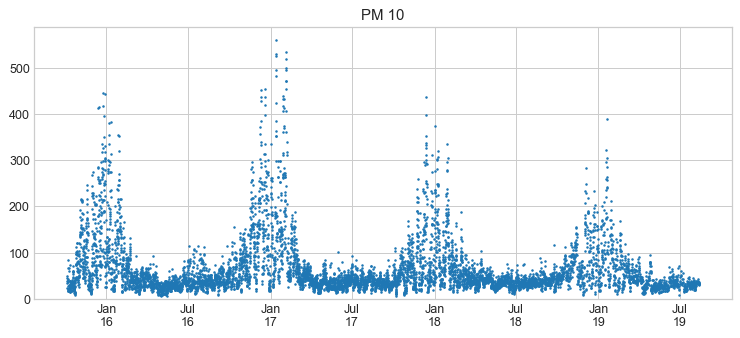

In [9]:
fig = plt.figure(figsize=(10, 4), dpi=90)
plt.scatter(data.time, data.pm10,
            marker='.', s=4)
plt.gca().xaxis.set_major_formatter(DateFormatter('%b\n%y'))
plt.gca().set(title='PM 10', ylim=(0, None))
None

## Model

We are fitting a three-component model using the slow, yearly trend, the monthly periodicity and the location of that measurment station, in the log-scale:

$$ \log pm_{10} = \overline{log(pm_{10})} + Y_{year} + M_{year, month} + P_{place} $$


The monthly effect is modeled as a product of a yearly changing magnitude $b$ and a periodical component $monthly$:


$$ M_{year, month} = (b_{year} + 1) monthly_{month} $$

The slow trend $a = Y$ and the magnitude $b$ are treated as covariates and are drawn from a hyperprior:

$$ \big(a, b \big) \sim \text{Normal}(0, \text{cholesky_covariance} = K) $$

$$ K \sim LKJCholesky(\eta = 1, \sigma \sim \text{Exponential}(2) ) $$

Them periodical component is also drawn from a hyperprior:

$$ monthly \sim \text{Normal}(0, \sigma_{m}) $$

$$ \sigma_m \sim \text{Exponential}(1) $$

The location has a similar threatment:

$$ P \sim Normal(0, \sigma_p) $$

$$ \sigma_P \sim \text{Exponential}(1) $$

Finally, for the likelihood of the inference we use log-normal, as it appears that the top-end tails are wider where the variance is bigger. Also, we use a separate variance for each month:

$$ observed \sim \text{Lognormal}(\log{pm_{10}}, \theta_{month}) $$

$$ \theta \sim \text{Exponential}(1) $$

In [10]:
with pm.Model() as m1:
    # yearly coeficients
    K_year = pm.LKJCholeskyCov(
        'K_year', n=2, eta=1,
        sd_dist=pm.Exponential.dist(lam=1/0.5, shape=2))
    coef_year = pm.MvNormal(
        'coef_year', mu=0,
        chol=pm.expand_packed_triangular(2, K_year),
        shape=(5, 2))
    
    # yearly trend
    a_year = pm.Deterministic('a_year', coef_year[:, 0])
    # magnitude of periodicity
    b_year = pm.Deterministic('b_year', 1 + coef_year[:, 1])

    # monthly effect
    month_bar = pm.Exponential('month_bar', lam=1)
    monthly = pm.Normal('monthly', mu=0, sd=month_bar,
                        shape=12)

    # location effect
    place_bar = pm.Exponential('place_bar', lam=1)
    place = pm.Normal('place', mu=0, sd=place_bar,
                      shape=data.place_i.nunique())

    avg_log_pm10 = (
        np.log(data.pm10).mean()
        + a_year[data.year_i.values]
        + b_year[data.year_i.values]
            * monthly[data.time.dt.month.values - 1]
    )

    log_pm10 = pm.Deterministic(
        'log_pm10',
        avg_log_pm10 + place[data.place_i.values]
    )

    # variable volatility
    sigma = pm.Exponential('sigma', lam=1, shape=12)
    sigma_i = sigma[data.time.dt.month.values - 1]

    # inference
    obs = pm.Lognormal('obs', mu=log_pm10,
                       sigma=sigma_i,
                       observed=data.pm10.values)

    pm10 = pm.Deterministic('pm10', pm.math.exp(avg_log_pm10 + sigma_i/2.))

    m1.trace = pm.sample(4000, tune=3000, chains=2)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


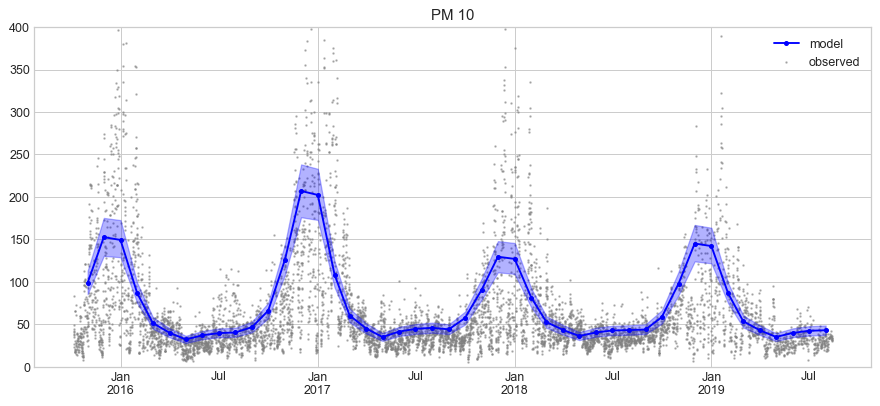

In [12]:
tmp = pd.DataFrame(m1.trace['pm10']).apply(summarize()).T.join(data.time.to_frame())
tmp = tmp[tmp.time.dt.day == 1]
tmp = tmp.drop_duplicates().sort_values('time').reset_index(drop=True)

fig = plt.figure(figsize=(12, 5), dpi=90)

plt.scatter(data.time, data.pm10,
            marker='.', alpha=.5, s=4, color='gray', label='observed')
plt.plot(tmp.time, tmp.mean_, label='model',
            marker='.', color='b')
plt.fill_between(tmp.time, tmp.lower, tmp.upper,
                 color='b', alpha=.3)

plt.gca().xaxis.set(
    major_formatter = DateFormatter('%b\n%Y'),
    minor_formatter = DateFormatter('%b'),
    minor_locator = MonthLocator(bymonth=[1, 7]),
    major_locator = YearLocator(month=1)
)
plt.gca().set(title='PM 10',
              ylim=(0, 400)
)
plt.legend()
None

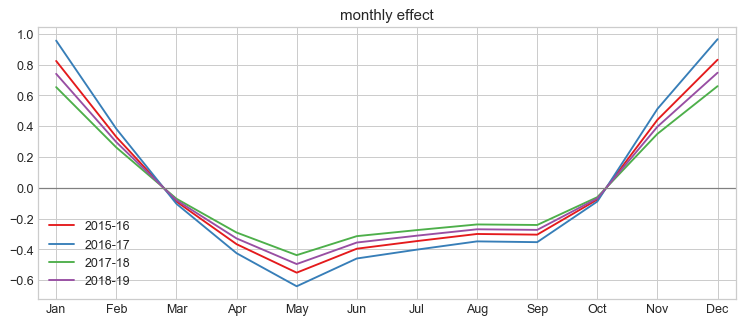

In [13]:
plt.figure(figsize=(10, 4), dpi=90)

b_year_tr = pd.DataFrame(m1.trace['b_year']).apply(summarize()).T.mean_.values.reshape(-1, 1)
monthly_tr = pd.DataFrame(m1.trace['monthly']).apply(summarize()).T.mean_

for sub, l, c in zip((b_year_tr * monthly_tr.values.reshape(1, -1)),
                     ['2015-16', '2016-17', '2017-18', '2018-19'],
                     Set1.colors):
    plt.plot(sub, label=l, c=c)

plt.axhline(0, linewidth=1, color='gray')

plt.gca().set(
    xticks=range(12),
    xticklabels=[month_abbr[i+1] for i in range(12)],
    title='monthly effect',
    xlim=(-0.3, 11.3)
)

plt.legend()
None

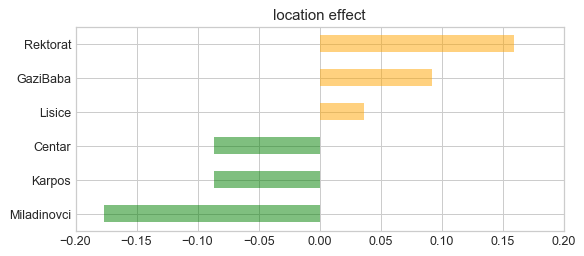

In [15]:
tmp = (
    pd.Series(m1.trace['place'].mean(axis=0), name='place_eff').to_frame()
    .join(
        data[['place', 'place_i']].drop_duplicates().set_index('place_i').sort_index()
    )
    .set_index('place')
    .place_eff.sort_values()
)

plt.figure(figsize=(7, 3), dpi=90)
ax = tmp.plot.barh(color=tmp.map(lambda x: 'orange' if x > 0 else 'g'),
                   alpha=.5)
ax.set(title='location effect', ylabel='',
       xlim=(-0.2, 0.2))
None

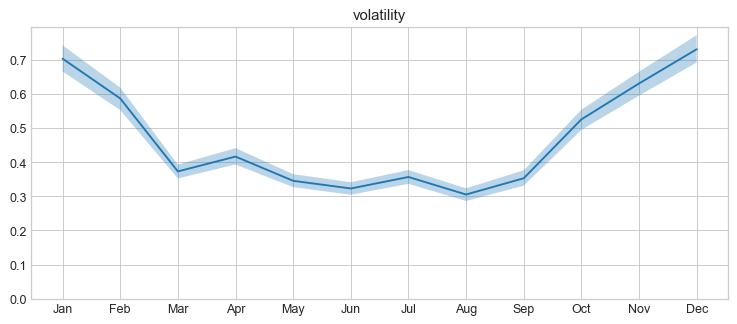

In [16]:
fig = plt.figure(figsize=(10, 4), dpi=90)

vol_tr = pd.DataFrame(m1.trace['sigma']).apply(summarize()).T

plt.plot(vol_tr.mean_)
plt.fill_between(range(12), vol_tr.lower, vol_tr.upper,
                 alpha=.3)
plt.gca().set(xticklabels=[month_abbr[i+1] for i in range(12)],
              xticks=range(12),
              title='volatility',
              ylim=(0, None))
None